# Keras Variational Autoencoder Example

This script is an example from Keras on how to build a variational autoencoder with deconvolution layers on the MNIST dataset.

This notebook is mainly used to accompany my blog post http://satisficing.briankeng.com/posts/variational-autoencoders/ .  I only did some very minor like changing the latent dimensions, randomly sampling digits (instead of displaying the manifold) and make some small annotations along the way.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.stats import norm
from IPython.display import display

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

batch_size = 200
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 64
intermediate_dim = 128
epsilon_std = 1.0
epochs = 20

## Encoder Structure

- 4 convolution layers
- 2 dense fully connected layer
- mean and variance each get another dense fully connnected layer

In [3]:
x = Input(batch_shape=(batch_size,) + original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden1 = Dense(intermediate_dim, activation='relu')(flat)
hidden2 = Dense(intermediate_dim, activation='relu')(hidden1)

z_mean = Dense(latent_dim)(hidden2)
z_log_var = Dense(latent_dim)(hidden2)


# Reparameterization Trick

Use the "reparameterization trick" here to ensure that we can back-propagate the error through the sampling operation.  Notice that we never have to backpropagate "through" the sampling operation `epsilon`, only through `z_mean` and `z_log_var`.

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder Structure

From the `z` latent variable input:

- 2 Fully connected layer
- 4 Deconvolution layers, the last of which "squashes" the output to be between [0,1] using a sigmoid function

In [5]:
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters, num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# Variational Loss/Objective Function

Here is our variational loss function: 

$$
E_{z\sim Q}[\log P(X|z)] - \mathcal{D}(Q(z|X) || P(z))
$$

The difference here is that we're using a Bernoulli distribution on the output instead of a normal because our output pixels are between $[0,1]$.  The log-likelihood (`xent_loss`) of a Bernoulli ends up being the same expression as binary cross-entropy (within a constant).  The `kl_loss` term is a simply the KL divergence between two normal distributions.

In [6]:
def vae_loss(x, x_decoded_mean):
    # NOTE: binary_crossentropy expects a batch_size by dim
    # for x and x_decoded_mean, so we MUST flatten these!
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (200, 28, 28, 1)      0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (200, 28, 28, 1)      5                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (200, 14, 14, 64)     320                                          
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (200, 14, 14, 64)     36928                                        
___________________________________________________________________________________________

# Fitting

In [7]:
start = time.time()
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 12s - loss: 214.9105 - val_loss: 179.6750
Epoch 2/20
60000/60000 [==============================] - 11s - loss: 156.3168 - val_loss: 145.9180
Epoch 3/20
60000/60000 [==============================] - 12s - loss: 133.4183 - val_loss: 123.9135
Epoch 4/20
60000/60000 [==============================] - 12s - loss: 119.6960 - val_loss: 115.2100
Epoch 5/20
60000/60000 [==============================] - 12s - loss: 110.9129 - val_loss: 105.7210
Epoch 6/20
60000/60000 [==============================] - 12s - loss: 105.0619 - val_loss: 99.9654
Epoch 7/20
60000/60000 [==============================] - 12s - loss: 100.8604 - val_loss: 99.6401
Epoch 8/20
60000/60000 [==============================] - 12s - loss: 97.8517 - val_loss: 95.7522
Epoch 9/20
60000/60000 [==============================] - 12s - loss: 95.4655 - val_loss: 97.2807
Epoch 10/20
60000/60000 [==============================]

# Encoder and Latent Representation

Use the same layers to build up a encoding layer to get an idea of what the latent representation ($z$) looks like in 2D with respect to their actual digit values.  (Probably better to use t-SNE instead of just looking at the first 2 dimensions)

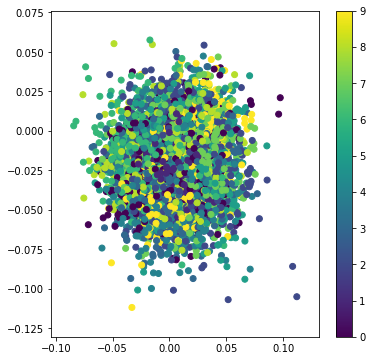

In [8]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# Decoder / Generator Model

We'll build up the generator model (re-using the layers we trained before) and generate a grid of random digits sampling our latent variables from our standard normal distribution.  Recall, the input to our network are the $z$ values drawn from our standard normal distribution, while the output are our pixel values (between 0 and 1).

In [9]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

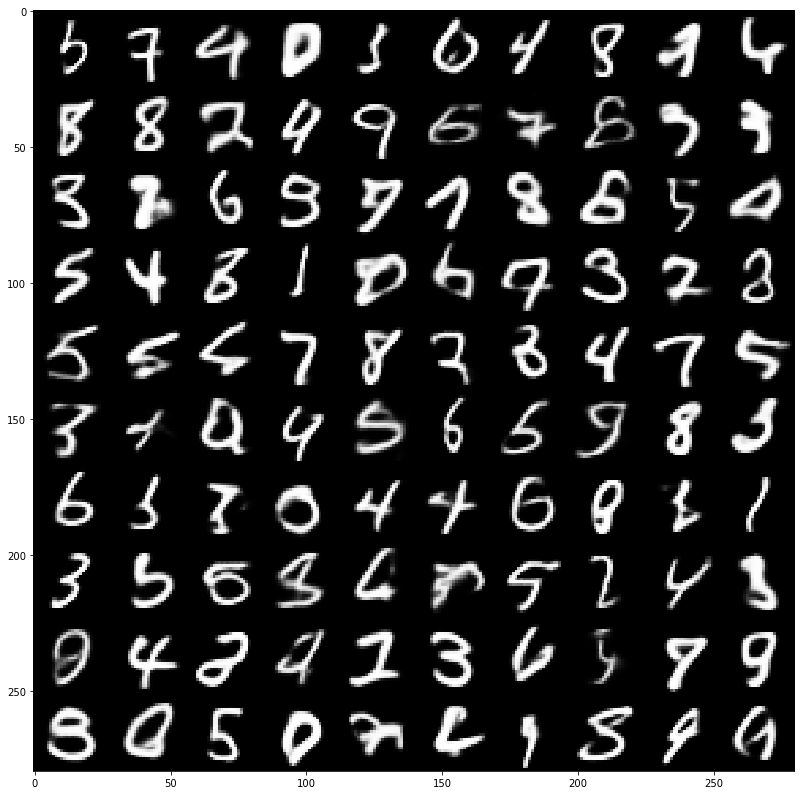

In [10]:
# display a grid of randomly sampled digits
# figure with 15x15 digits
digit_size = 28
n = 10  
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict(z_sample, batch_size=1)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        x = i * digit_size
        y = j * digit_size
        figure[x:x + digit_size, y:y + digit_size] = digit

plt.figure(figsize=(14, 14))
plt.imshow(figure, cmap='Greys_r')
plt.show()